In [1]:
import sys
import os, glob
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import gc
import collections
import scipy
from sklearn.metrics import mean_squared_error

In [5]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
rmse_results_folder = 'rmse_grid_220911/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'
inFilesDir = inDirName+interim_data_folder+rmse_results_folder

## Input Files

In [6]:
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

In [7]:
%%time
# Drop all NaN-valued grid points
flux_clean = flux_clean.dropna('time',how='all')
flux_clean = flux_clean.dropna('y',how='all')
flux_clean = flux_clean.dropna('x',how='all')
flux_clean = flux_clean.drop("month")

CPU times: user 7.19 s, sys: 10.2 s, total: 17.4 s
Wall time: 22.1 s


In [9]:
%%time
model = EOF(flux_clean)
model.solve()
xeofs_eofs = model.eofs()
xeofs_pcs = model.pcs()
xeofs_n_modes = model.n_modes

CPU times: user 2min 30s, sys: 49.2 s, total: 3min 20s
Wall time: 53.9 s


In [22]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 1
t_length = xeofs_pcs.shape[0]

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,xeofs_pcs.shape[0],xeofs_pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(xeofs_n_modes):
        fl = xeofs_pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization i, mode: {}'.format(m))

calculated ifft for realization i, mode: 0
calculated ifft for realization i, mode: 1
calculated ifft for realization i, mode: 2
calculated ifft for realization i, mode: 3
calculated ifft for realization i, mode: 4
calculated ifft for realization i, mode: 5
calculated ifft for realization i, mode: 6
calculated ifft for realization i, mode: 7
calculated ifft for realization i, mode: 8
calculated ifft for realization i, mode: 9
calculated ifft for realization i, mode: 10
calculated ifft for realization i, mode: 11
calculated ifft for realization i, mode: 12
calculated ifft for realization i, mode: 13
calculated ifft for realization i, mode: 14
calculated ifft for realization i, mode: 15
calculated ifft for realization i, mode: 16
calculated ifft for realization i, mode: 17
calculated ifft for realization i, mode: 18
calculated ifft for realization i, mode: 19
calculated ifft for realization i, mode: 20
calculated ifft for realization i, mode: 21
calculated ifft for realization i, mode: 2

calculated ifft for realization i, mode: 587
calculated ifft for realization i, mode: 588
calculated ifft for realization i, mode: 589
calculated ifft for realization i, mode: 590
calculated ifft for realization i, mode: 591
calculated ifft for realization i, mode: 592
calculated ifft for realization i, mode: 593
calculated ifft for realization i, mode: 594
calculated ifft for realization i, mode: 595
calculated ifft for realization i, mode: 596
calculated ifft for realization i, mode: 597
calculated ifft for realization i, mode: 598
calculated ifft for realization i, mode: 599
calculated ifft for realization i, mode: 600
calculated ifft for realization i, mode: 601
calculated ifft for realization i, mode: 602
calculated ifft for realization i, mode: 603
calculated ifft for realization i, mode: 604
calculated ifft for realization i, mode: 605
calculated ifft for realization i, mode: 606
calculated ifft for realization i, mode: 607
calculated ifft for realization i, mode: 608
calculated

calculated ifft for realization i, mode: 1183
calculated ifft for realization i, mode: 1184
calculated ifft for realization i, mode: 1185
calculated ifft for realization i, mode: 1186
calculated ifft for realization i, mode: 1187
calculated ifft for realization i, mode: 1188
calculated ifft for realization i, mode: 1189
calculated ifft for realization i, mode: 1190
calculated ifft for realization i, mode: 1191
calculated ifft for realization i, mode: 1192
calculated ifft for realization i, mode: 1193
calculated ifft for realization i, mode: 1194
calculated ifft for realization i, mode: 1195
calculated ifft for realization i, mode: 1196
calculated ifft for realization i, mode: 1197
calculated ifft for realization i, mode: 1198
calculated ifft for realization i, mode: 1199
calculated ifft for realization i, mode: 1200
calculated ifft for realization i, mode: 1201
calculated ifft for realization i, mode: 1202
calculated ifft for realization i, mode: 1203
calculated ifft for realization i,

In [ ]:
rmse_grid_1500 = xr.open_dataset("rmse_grid_ALLEOFS.nc")
rmse_grid_1500 = rmse_grid_1500.__xarray_dataarray_variable__

In [ ]:
plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
ax.gridlines()

colorbarmax = np.nanmax([rmse_grid_1500])
colorbarmin = np.nanmin([rmse_grid_1500])

rmse_grid_1500.plot(cmap="YlGn",vmax = colorbarmax, vmin = colorbarmin, cbar_kwargs={"label": "RMSE"})
plt.title("RMSE when reconstructed data includes all EOFs")
plt.savefig("rmse_grid_ALLEOFS.png")

In [7]:
inFilesResultsDir = inFilesDir+"results/"
inFilesResultsDir

'/Users/smurugan9/research/aislens/aislens_emulation/data/interim/rmse_grid_220911/results/'

In [59]:
from parse import parse

In [60]:
rmse_grid = np.empty((1500,457,552))
rmse_grid = xr.DataArray(rmse_grid,coords=datatmp.coords,dims = datatmp.dims,attrs=datatmp.attrs)
for file in sorted(glob.glob(inFilesResultsDir+"rmse_grid_comparisons_EOF_*.nc")):
    (path, inFileName) = os.path.split(file)
    ds = xr.open_dataset(inFilesResultsDir+inFileName).__xarray_dataarray_variable__
    #ds = ds.where(ds>0)
    pattern = 'rmse_grid_comparisons_EOF_{}.nc'
    t = parse(pattern, inFileName)
    mode = int(t[0])
    print("assigning data to mode {}".format(mode))
    rmse_grid[mode-1,:,:] = ds

assigning data to mode 1
assigning data to mode 2
assigning data to mode 3
assigning data to mode 4
assigning data to mode 5
assigning data to mode 6
assigning data to mode 7
assigning data to mode 8
assigning data to mode 9
assigning data to mode 10
assigning data to mode 11
assigning data to mode 12
assigning data to mode 13
assigning data to mode 14
assigning data to mode 15
assigning data to mode 16
assigning data to mode 17
assigning data to mode 18
assigning data to mode 19
assigning data to mode 20
assigning data to mode 21
assigning data to mode 22
assigning data to mode 23
assigning data to mode 24
assigning data to mode 25
assigning data to mode 26
assigning data to mode 27
assigning data to mode 28
assigning data to mode 29
assigning data to mode 30
assigning data to mode 31
assigning data to mode 32
assigning data to mode 33
assigning data to mode 34
assigning data to mode 35
assigning data to mode 36
assigning data to mode 37
assigning data to mode 38
assigning data to mod

assigning data to mode 342
assigning data to mode 343
assigning data to mode 344
assigning data to mode 345
assigning data to mode 346
assigning data to mode 347
assigning data to mode 348
assigning data to mode 349
assigning data to mode 350
assigning data to mode 351
assigning data to mode 352
assigning data to mode 353
assigning data to mode 354
assigning data to mode 355
assigning data to mode 356
assigning data to mode 357
assigning data to mode 358
assigning data to mode 359
assigning data to mode 360
assigning data to mode 361
assigning data to mode 362
assigning data to mode 363
assigning data to mode 364
assigning data to mode 365
assigning data to mode 366
assigning data to mode 367
assigning data to mode 368
assigning data to mode 369
assigning data to mode 370
assigning data to mode 371
assigning data to mode 372
assigning data to mode 373
assigning data to mode 374
assigning data to mode 375
assigning data to mode 376
assigning data to mode 377
assigning data to mode 378
a

assigning data to mode 651
assigning data to mode 652
assigning data to mode 653
assigning data to mode 654
assigning data to mode 655
assigning data to mode 656
assigning data to mode 657
assigning data to mode 658
assigning data to mode 659
assigning data to mode 660
assigning data to mode 661
assigning data to mode 662
assigning data to mode 663
assigning data to mode 664
assigning data to mode 665
assigning data to mode 666
assigning data to mode 667
assigning data to mode 668
assigning data to mode 669
assigning data to mode 670
assigning data to mode 671
assigning data to mode 672
assigning data to mode 673
assigning data to mode 674
assigning data to mode 675
assigning data to mode 676
assigning data to mode 677
assigning data to mode 678
assigning data to mode 679
assigning data to mode 680
assigning data to mode 681
assigning data to mode 682
assigning data to mode 683
assigning data to mode 684
assigning data to mode 685
assigning data to mode 686
assigning data to mode 687
a

assigning data to mode 984
assigning data to mode 985
assigning data to mode 986
assigning data to mode 987
assigning data to mode 988
assigning data to mode 989
assigning data to mode 990
assigning data to mode 991
assigning data to mode 992
assigning data to mode 993
assigning data to mode 994
assigning data to mode 995
assigning data to mode 996
assigning data to mode 997
assigning data to mode 998
assigning data to mode 999
assigning data to mode 1000
assigning data to mode 1001
assigning data to mode 1002
assigning data to mode 1003
assigning data to mode 1004
assigning data to mode 1005
assigning data to mode 1006
assigning data to mode 1007
assigning data to mode 1008
assigning data to mode 1009
assigning data to mode 1010
assigning data to mode 1011
assigning data to mode 1012
assigning data to mode 1013
assigning data to mode 1014
assigning data to mode 1015
assigning data to mode 1016
assigning data to mode 1017
assigning data to mode 1018
assigning data to mode 1019
assignin

assigning data to mode 1295
assigning data to mode 1296
assigning data to mode 1297
assigning data to mode 1298
assigning data to mode 1299
assigning data to mode 1300
assigning data to mode 1301
assigning data to mode 1302
assigning data to mode 1303
assigning data to mode 1304
assigning data to mode 1305
assigning data to mode 1306
assigning data to mode 1307
assigning data to mode 1308
assigning data to mode 1309
assigning data to mode 1310
assigning data to mode 1311
assigning data to mode 1312
assigning data to mode 1313
assigning data to mode 1314
assigning data to mode 1315
assigning data to mode 1316
assigning data to mode 1317
assigning data to mode 1318
assigning data to mode 1319
assigning data to mode 1320
assigning data to mode 1321
assigning data to mode 1322
assigning data to mode 1323
assigning data to mode 1324
assigning data to mode 1325
assigning data to mode 1326
assigning data to mode 1327
assigning data to mode 1328
assigning data to mode 1329
assigning data to mo

In [61]:
rmse_grid

<xarray.DataArray (mode: 1500, y: 457, x: 552)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    lat          (y, x) float64 dask.array<chunksize=(457, 552), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(457, 552), meta=np.ndarray>
  * x            (x) float64 -2.69e+06 -2.68e+06 -2.67e+06 ... 2.81e+06 2.82e+06
  * y            (y) float64 -2.32e+06 -2.31e+06 -2.3e+06 ... 2.23e+06 2.24e+06
    spatial_ref  int64 0
  * mode         (mode) int64 0 1 2 3 4 5 6 ... 1494 1495 1496 1497 1498 1499

In [62]:
rmse_grid.to_netcdf(inFilesResultsDir+"rmse_grid.nc")

In [74]:
rmseidxmin = rmse_grid.idxmin('mode')

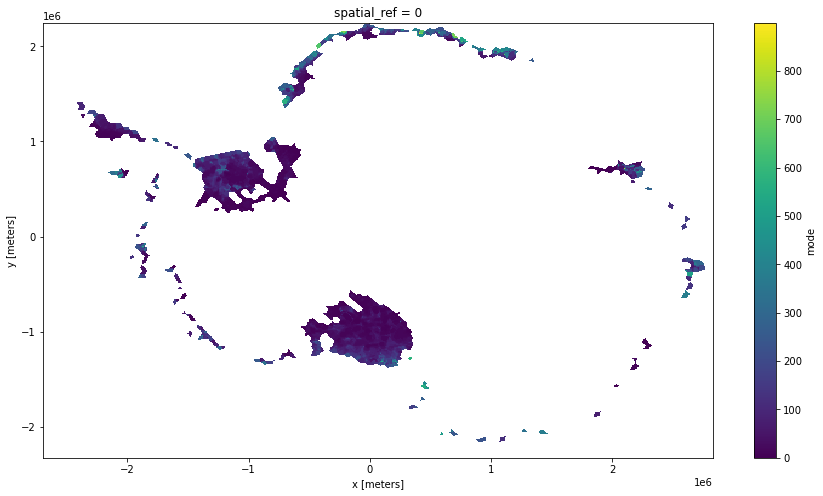

In [75]:
plt.figure(figsize=(15,8))
rmseidxmin.plot()

In [333]:
#rmse_grid = np.empty((1500,457,552))
#rmse_grid = xr.DataArray(rmse_grid,coords=ds.coords,dims = ds.dims,attrs=ds.attrs)
for file in sorted(glob.glob(inFilesDir+"rmse_grid_comparisons_EOF_*.nc")):
    (path, inFileName) = os.path.split(file)
    ds = xr.open_dataset(inFilesDir+inFileName).__xarray_dataarray_variable__
    ds = ds.where(ds>0)
    pattern = 'rmse_grid_comparisons_EOF_{}.nc'
    t = parse(pattern, inFileName)
    mode = t[0]
    numStr = mode.zfill(4)
    #numStr = int(numStr)
    print("mode {}".format(numStr))
    ds.to_netcdf(inFilesDir+"results/"+"rmse_grid_comparisons_EOF_{}.nc".format(numStr))

mode 0206
mode 0207
mode 0208
mode 0209
mode 0210
mode 0211
mode 0212
mode 0213
mode 0214
mode 0215
mode 0216
mode 0217
mode 0218
mode 0219
mode 0220
mode 0221
mode 0222


In [135]:
(path, inFileName) = os.path.split("rmse_grid_comparisons_EOF_1420.nc")

In [129]:
import glob, os
from parse import parse

In [137]:
pattern = 'rmse_grid_comparisons_EOF_{}.nc'
t = parse(pattern, inFileName)
int(t[0])

1420

In [51]:
datatmp = xr.open_mfdataset(inFilesDir+"results/"+"rmse_grid_comparisons_EOF_*.nc", combine="nested", concat_dim="mode")
datatmp = datatmp.assign_coords(mode=('mode',datatmp.mode.values))


In [54]:
datatmp = datatmp.__xarray_dataarray_variable__

In [ ]:
ds.to_netcdf(inFilesDir+"rmse_grid.nc")

In [292]:
pattern = 'rmse_grid_comparisons_EOF_{}.nc'
inFileName = 'rmse_grid_comparisons_EOF_0001.nc'
m = parse(pattern, inFileName)
m[0]

'0001'

In [301]:
%%time
for file in sorted(glob.glob(inFilesResultsDir+"rmse_grid_comparisons_EOF_*.nc")):
    (path, inFileName) = os.path.split(file)
    ds = xr.open_dataset(inFilesResultsDir+inFileName).__xarray_dataarray_variable__
    plt.figure(figsize=(20,12))
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.coastlines()
    ax.gridlines()
    pattern = 'rmse_grid_comparisons_EOF_{}.nc'
    m = parse(pattern, inFileName)
    print("mode {}".format(m[0]))
    ds.plot(cbar_kwargs={"label": "RMSE"})
    plt.title("PSD Comparison RMSE at Mode = {}".format(m[0]))
    plt.savefig(inFilesResultsDir+"figures/"+"rmse_grid_comparisons_EOF_{}.png".format(m[0]))
    plt.close()

mode 0001
mode 0002
mode 0003
mode 0004
mode 0005
mode 0006
mode 0007
mode 0008
mode 0009
mode 0010
mode 0011
mode 0012
mode 0013
mode 0014
mode 0015
mode 0016
mode 0017
mode 0018
mode 0019
mode 0020
mode 0021
mode 0022
mode 0023
mode 0024
mode 0025
mode 0026
mode 0027
mode 0028
mode 0029
mode 0030
mode 0031
mode 0032
mode 0033
mode 0034
mode 0035
mode 0036
mode 0037
mode 0038
mode 0039
mode 0040
mode 0041
mode 0042
mode 0043
mode 0044
mode 0045
mode 0046
mode 0047
mode 0048
mode 0049
mode 0050
mode 0051
mode 0052
mode 0053
mode 0054
mode 0055
mode 0056
mode 0057
mode 0058
mode 0059
mode 0060
mode 0061
mode 0062
mode 0063
mode 0064
mode 0065
mode 0066
mode 0067
mode 0068
mode 0069
mode 0070
mode 0071
mode 0072
mode 0073
mode 0074
mode 0075
mode 0076
mode 0077
mode 0078
mode 0079
mode 0080
mode 0081
mode 0082
mode 0083
mode 0084
mode 0085
mode 0086
mode 0087
mode 0088
mode 0089
mode 0090
mode 0091
mode 0092
mode 0093
mode 0094
mode 0095
mode 0096
mode 0097
mode 0098
mode 0099
mode 0100


mode 0821
mode 0822
mode 0823
mode 0824
mode 0825
mode 0826
mode 0827
mode 0828
mode 0829
mode 0830
mode 0831
mode 0832
mode 0833
mode 0834
mode 0835
mode 0836
mode 0837
mode 0838
mode 0839
mode 0840
mode 0841
mode 0842
mode 0843
mode 0844
mode 0845
mode 0846
mode 0847
mode 0848
mode 0849
mode 0850
mode 0851
mode 0852
mode 0853
mode 0854
mode 0855
mode 0856
mode 0857
mode 0858
mode 0859
mode 0860
mode 0861
mode 0862
mode 0863
mode 0864
mode 0865
mode 0866
mode 0867
mode 0868
mode 0869
mode 0870
mode 0871
mode 0872
mode 0873
mode 0874
mode 0875
mode 0876
mode 0877
mode 0878
mode 0879
mode 0880
mode 0881
mode 0882
mode 0883
mode 0884
mode 0885
mode 0886
mode 0887
mode 0888
mode 0889
mode 0890
mode 0891
mode 0892
mode 0893
mode 0894
mode 0895
mode 0896
mode 0897
mode 0898
mode 0899
mode 0900
mode 0901
mode 0902
mode 0903
mode 0904
mode 0905
mode 0906
mode 0907
mode 0908
mode 0909
mode 0910
mode 0911
mode 0912
mode 0913
mode 0914
mode 0915
mode 0916
mode 0917
mode 0918
mode 0919
mode 0920


Text(0.5, 1.0, 'PSD Comparison RMSE at Mode = 0222')

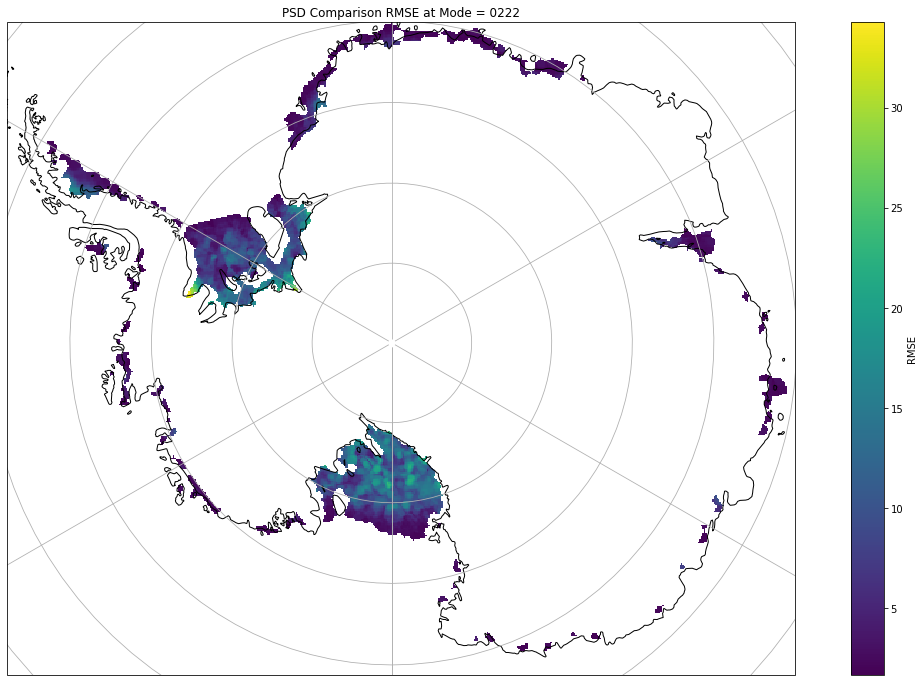

In [48]:
nmode = '0222'
plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
ax.gridlines()
dsn = xr.open_dataset(inFilesResultsDir+"rmse_grid_comparisons_EOF_{}.nc".format(nmode))
dsn = dsn.__xarray_dataarray_variable__
#dsn = dsn.where(dsn>0.00000000000000000001)
#dsn = dsn.where(dsn<200)
dsn.plot(cbar_kwargs={"label": "RMSE"})
plt.title("PSD Comparison RMSE at Mode = {}".format(nmode))

In [47]:
modes = list(range(222,223))
for mode in modes:
    nmode = str(mode).zfill(4)
    #plt.figure(figsize=(20,12))
    #ax = plt.axes(projection=ccrs.SouthPolarStereo())
    #ax.coastlines()
    #ax.gridlines()
    dsn = xr.open_dataset(inFilesResultsDir+"rmse_grid_comparisons_EOF_{}.nc".format(nmode))
    dsn = dsn.__xarray_dataarray_variable__
    dsn = dsn.where(dsn>0.00000000000000000001)
    dsn.to_netcdf(inFilesResultsDir+"rmse_grid_comparisons_EOF_{}_n.nc".format(nmode))
    #dsn = dsn.where(dsn<200)
    #dsn.plot(cbar_kwargs={"label": "RMSE"})
    #plt.title("PSD Comparison RMSE at Mode = {}".format(nmode))

Text(0.5, 1.0, 'PSD Comparison RMSE at Mode = 0002')

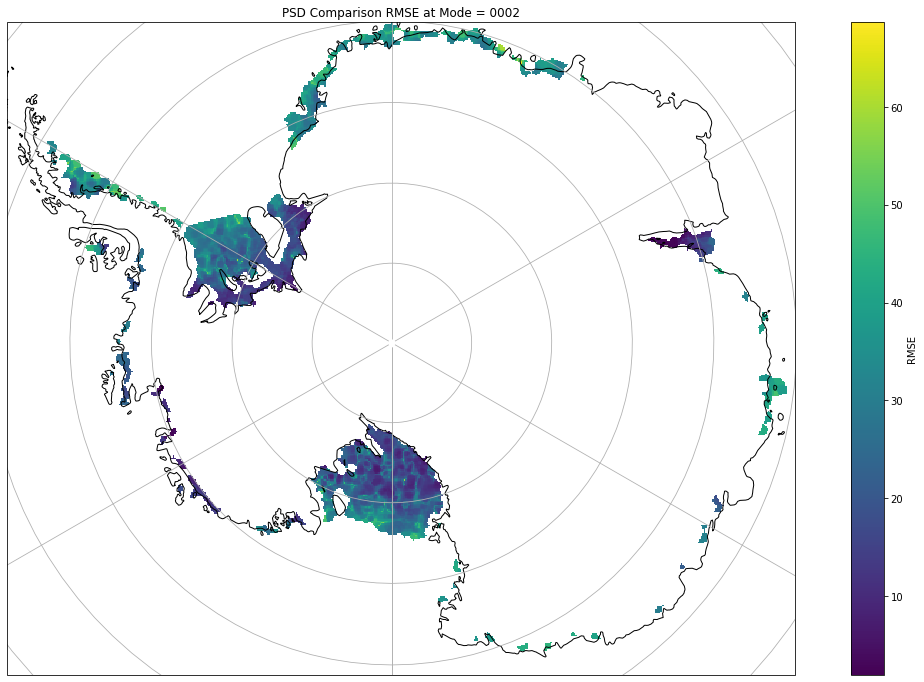

In [67]:
nmode = '0002'
plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
ax.gridlines()
dsn = xr.open_dataset("rmse_mode_{}.nc".format(nmode))
dsn = dsn.__xarray_dataarray_variable__
dsn = dsn.where(dsn>0.00000000000000000001)
#dsn = dsn.where(dsn<200)
dsn.plot(cbar_kwargs={"label": "RMSE"})
plt.title("PSD Comparison RMSE at Mode = {}".format(nmode))

Text(0.5, 1.0, 'PSD Comparison RMSE at Mode = 222')

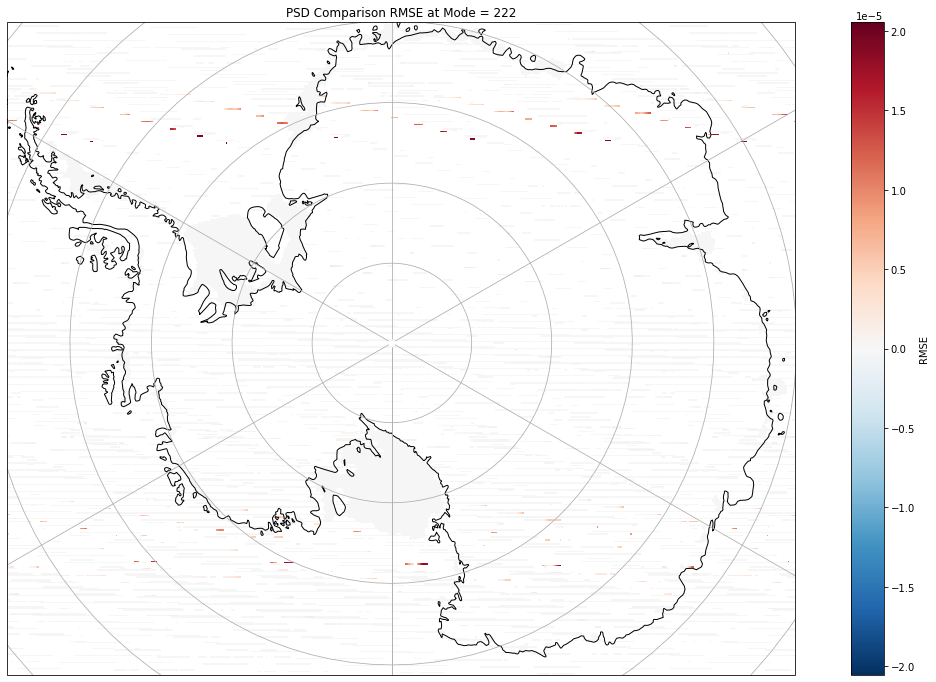

In [30]:
nmode = 222
plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
ax.gridlines()
dsn = xr.open_dataset(inFilesDir+"rmse_grid_comparisons_EOF_NEW_{}.nc".format(nmode))
dsn = dsn.__xarray_dataarray_variable__
#dsn = dsn.where(dsn>0)
#dsn = dsn.where(dsn<200)
dsn.plot(cbar_kwargs={"label": "RMSE"})
plt.title("PSD Comparison RMSE at Mode = {}".format(nmode))

In [332]:
xeofs_modes = list(range(206,223)) 
for mode in xeofs_modes:
    print(mode)

206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222


In [235]:
nmode = '1500'
#plt.figure(figsize=(25,12))
#ax = plt.axes(projection=ccrs.SouthPolarStereo())
#ax.coastlines()
#ax.gridlines()

dsn = xr.open_dataset(inFilesResultsDir+"rmse_grid_comparisons_EOF_{}.nc".format(nmode))
#dsn = xr.open_dataset("rmse_grid_comparisons_EOF_01_full.nc")
dsn = dsn.__xarray_dataarray_variable__

#colorbarmax = np.nanmax([dsn])
#colorbarmin = np.nanmin([dsn])
dsn = dsn.where(dsn>0.0000000001)
dsn = dsn.where(dsn<200)
dsn.to_netcdf(inFilesResultsDir+"rmse_grid_comparisons_EOF_{}_copy.nc".format(nmode))
#dsn.plot(
    #vmax = colorbarmax, 
    #vmin = colorbarmin
#    )

KeyboardInterrupt: 

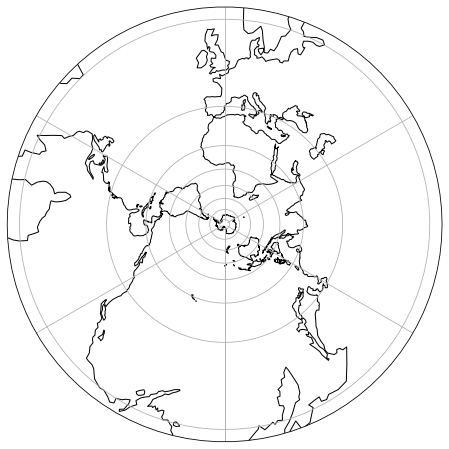

In [170]:
plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
ax.gridlines()

data = rmse_grid[556,:,:]
#data = data.where(data>0)
colorbarmax = np.nanmax([data])
colorbarmin = np.nanmin([data])

data.plot(cmap="YlGn",vmax = colorbarmax, vmin = colorbarmin, cbar_kwargs={"label": "RMSE"})
plt.title("RMSE when reconstructed data")
#plt.savefig("rmse_grid_ALLEOFS.png")

Text(0.5, 1.0, 'Minimum RMSE values across spatial grid')

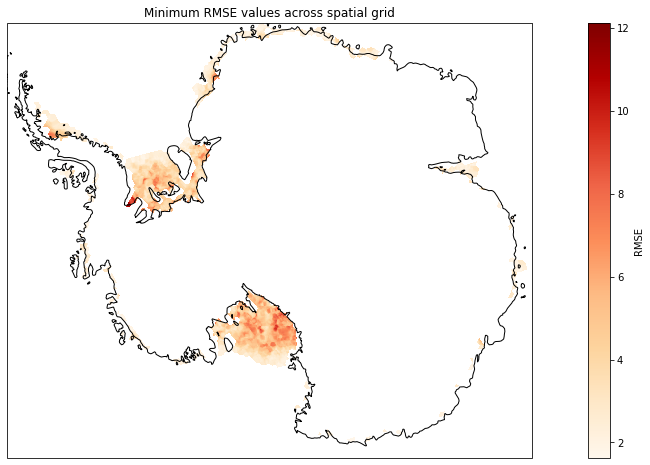

In [94]:
plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
#ax.gridlines()

data = ds.min(dim="mode")
data = data.where(data>0)
colorbarmax = np.nanmax([data])
colorbarmin = np.nanmin([data])

data.plot(cmap="OrRd",
          #vmax = colorbarmax,
          #vmin = colorbarmin,
          cbar_kwargs={"label": "RMSE"}
         )
plt.title("Minimum RMSE values across spatial grid")
#plt.savefig("rmse_grid_ALLEOFS.png")

Text(0.5, 1.0, 'Mode # for minimum RMSE values across spatial grid')

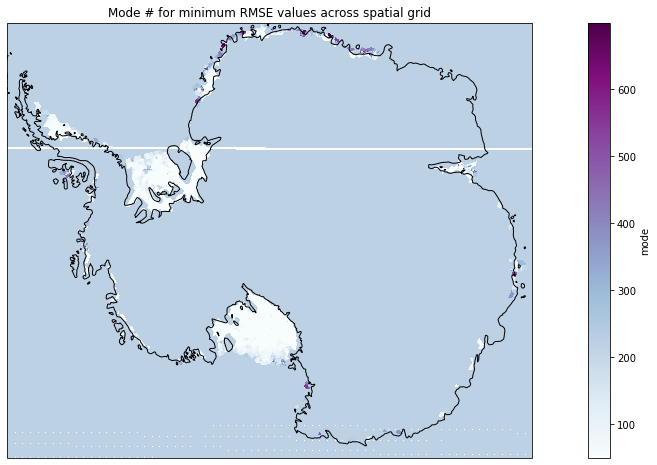

In [279]:
plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
#ax.gridlines()

data = rmse_grid[50:700].idxmin(dim="mode")
#data = data.where(data>0.0001)
colorbarmax = np.nanmax([data])/3
colorbarmin = np.nanmin([data])

data.plot(cmap="BuPu",
          #vmax = colorbarmax,
          #vmin = colorbarmin,
          #cbar_kwargs={"label": "RMSE"}
         )
plt.title("Mode # for minimum RMSE values across spatial grid")
#plt.savefig("rmse_grid_ALLEOFS.png")

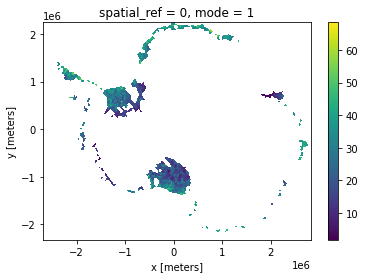

In [284]:
rm = rmse_grid[1,:,:]
rm.plot()

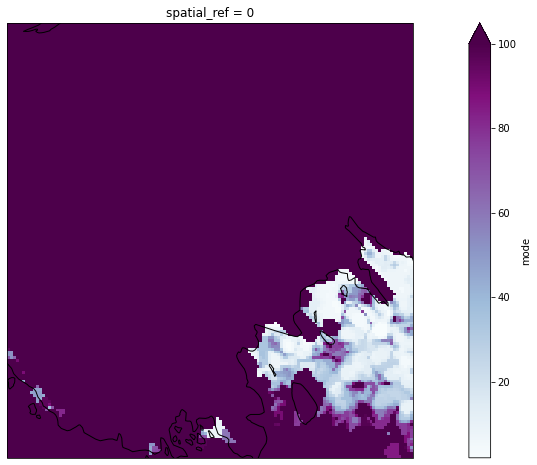

In [195]:
plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
data[100:250,130:270].plot(cmap="BuPu",
          vmax = 100
          #vmin = colorbarmin,
          #cbar_kwargs={"label": "RMSE"}
         )

In [ ]:
data.to_netcdf(inFilesDir+"min_rmse_EOF_grid.nc")

In [ ]:
plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
ax.gridlines()
colorbarmax = np.nanmax([data])
colorbarmin = np.nanmin([data])
data.plot(cmap="BuPu",
          vmax = colorbarmax,
          vmin = colorbarmin,
         )
plt.title("Mode # for minimum RMSE values across spatial grid")

In [110]:
eof_minrmse = ds.idxmin(dim="mode")
minrmse = ds.min(dim="mode")
#allrec = ds[943,:,:]

In [302]:
eof_minrmse = rmse_grid[0:205].idxmin(dim="mode")
minrmse = rmse_grid[0:205].min(dim="mode")
#allrec = ds[943,:,:]

In [303]:
eof_minrmse = eof_minrmse.where(eof_minrmse>0)
minrmse = minrmse.where(minrmse>0)
#allrec = allrec.where(allrec>0)

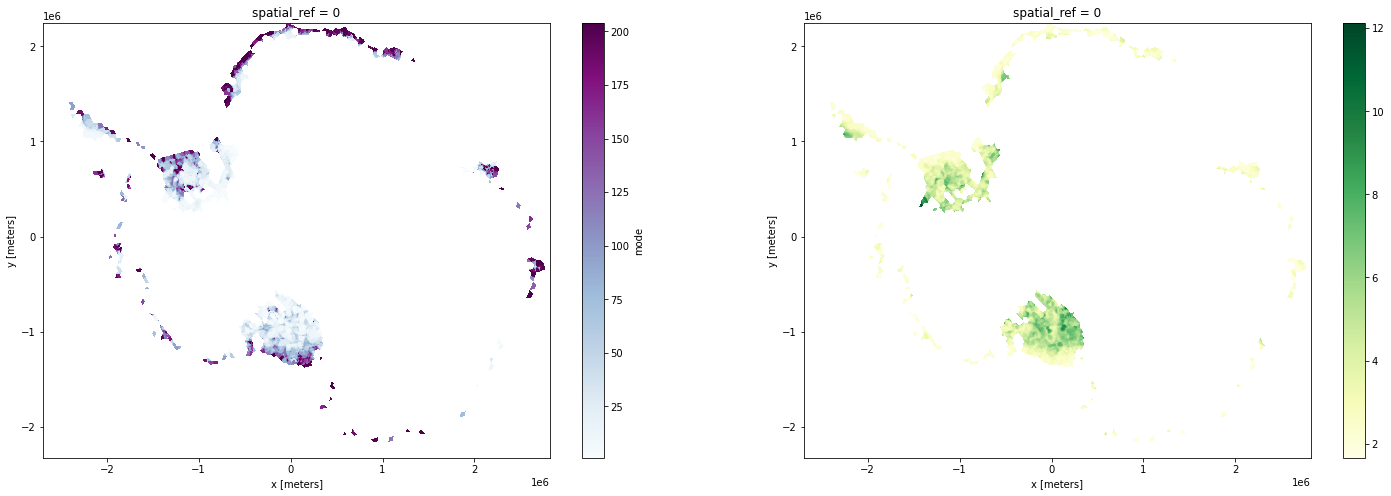

In [304]:
plt.figure(figsize=(25,8))
plt.axes(projection=ccrs.SouthPolarStereo())
#colorbarmax = np.nanmax([data])
#colorbarmin = np.nanmin([data])

plt.subplot(121)
#plt.axes(projection=ccrs.SouthPolarStereo())
eof_minrmse.plot(cmap="BuPu")

plt.subplot(122)
#ax2 = plt.axes(projection=ccrs.SouthPolarStereo())
#ax2.coastlines()
#ax2.gridlines()
minrmse.plot(cmap="YlGn")

#plt.subplot(133)
#ax3 = plt.axes(projection=ccrs.SouthPolarStereo())
#ax3.coastlines()
#ax3.gridlines()
#allrec.plot(cmap="YlGn")

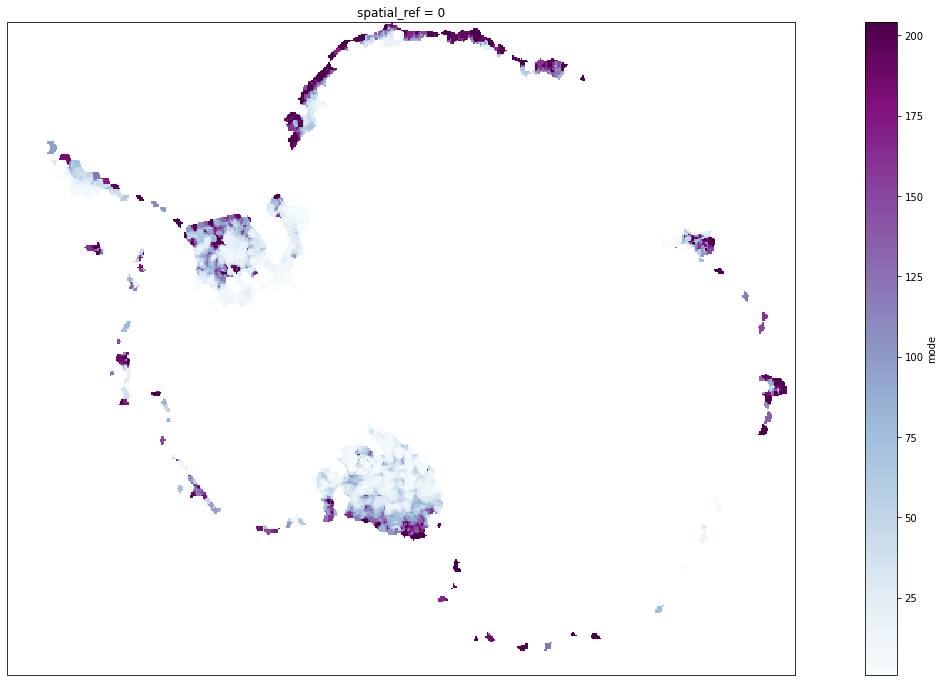

In [305]:
plt.figure(figsize=(25,12))
plt.axes(projection=ccrs.SouthPolarStereo())
eof_minrmse.plot(cmap="BuPu")

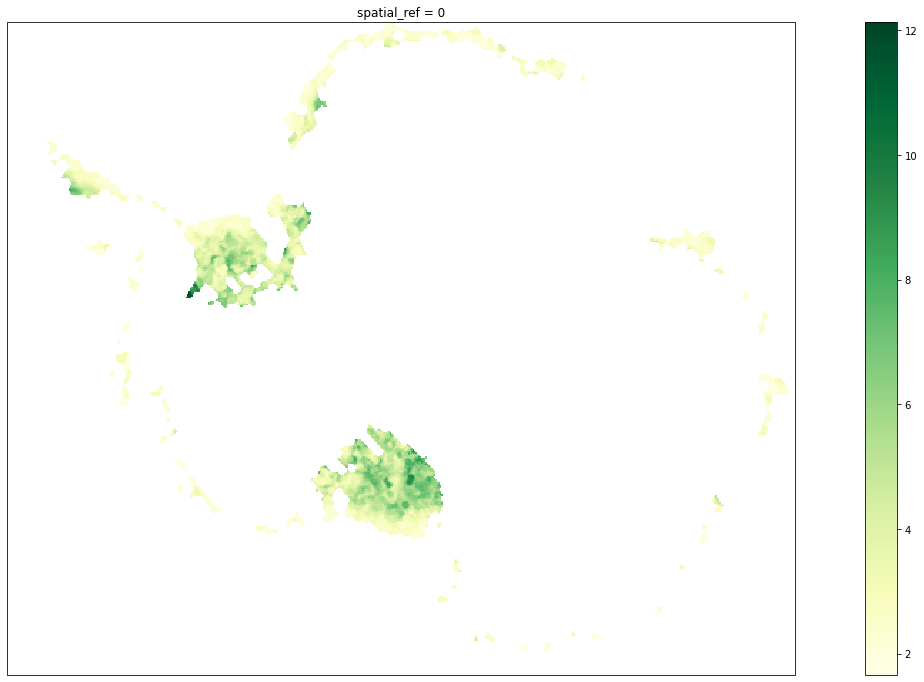

In [306]:
plt.figure(figsize=(25,12))
plt.axes(projection=ccrs.SouthPolarStereo())
minrmse.plot(cmap="YlOrRd", vmax = 30, vmin = 0)

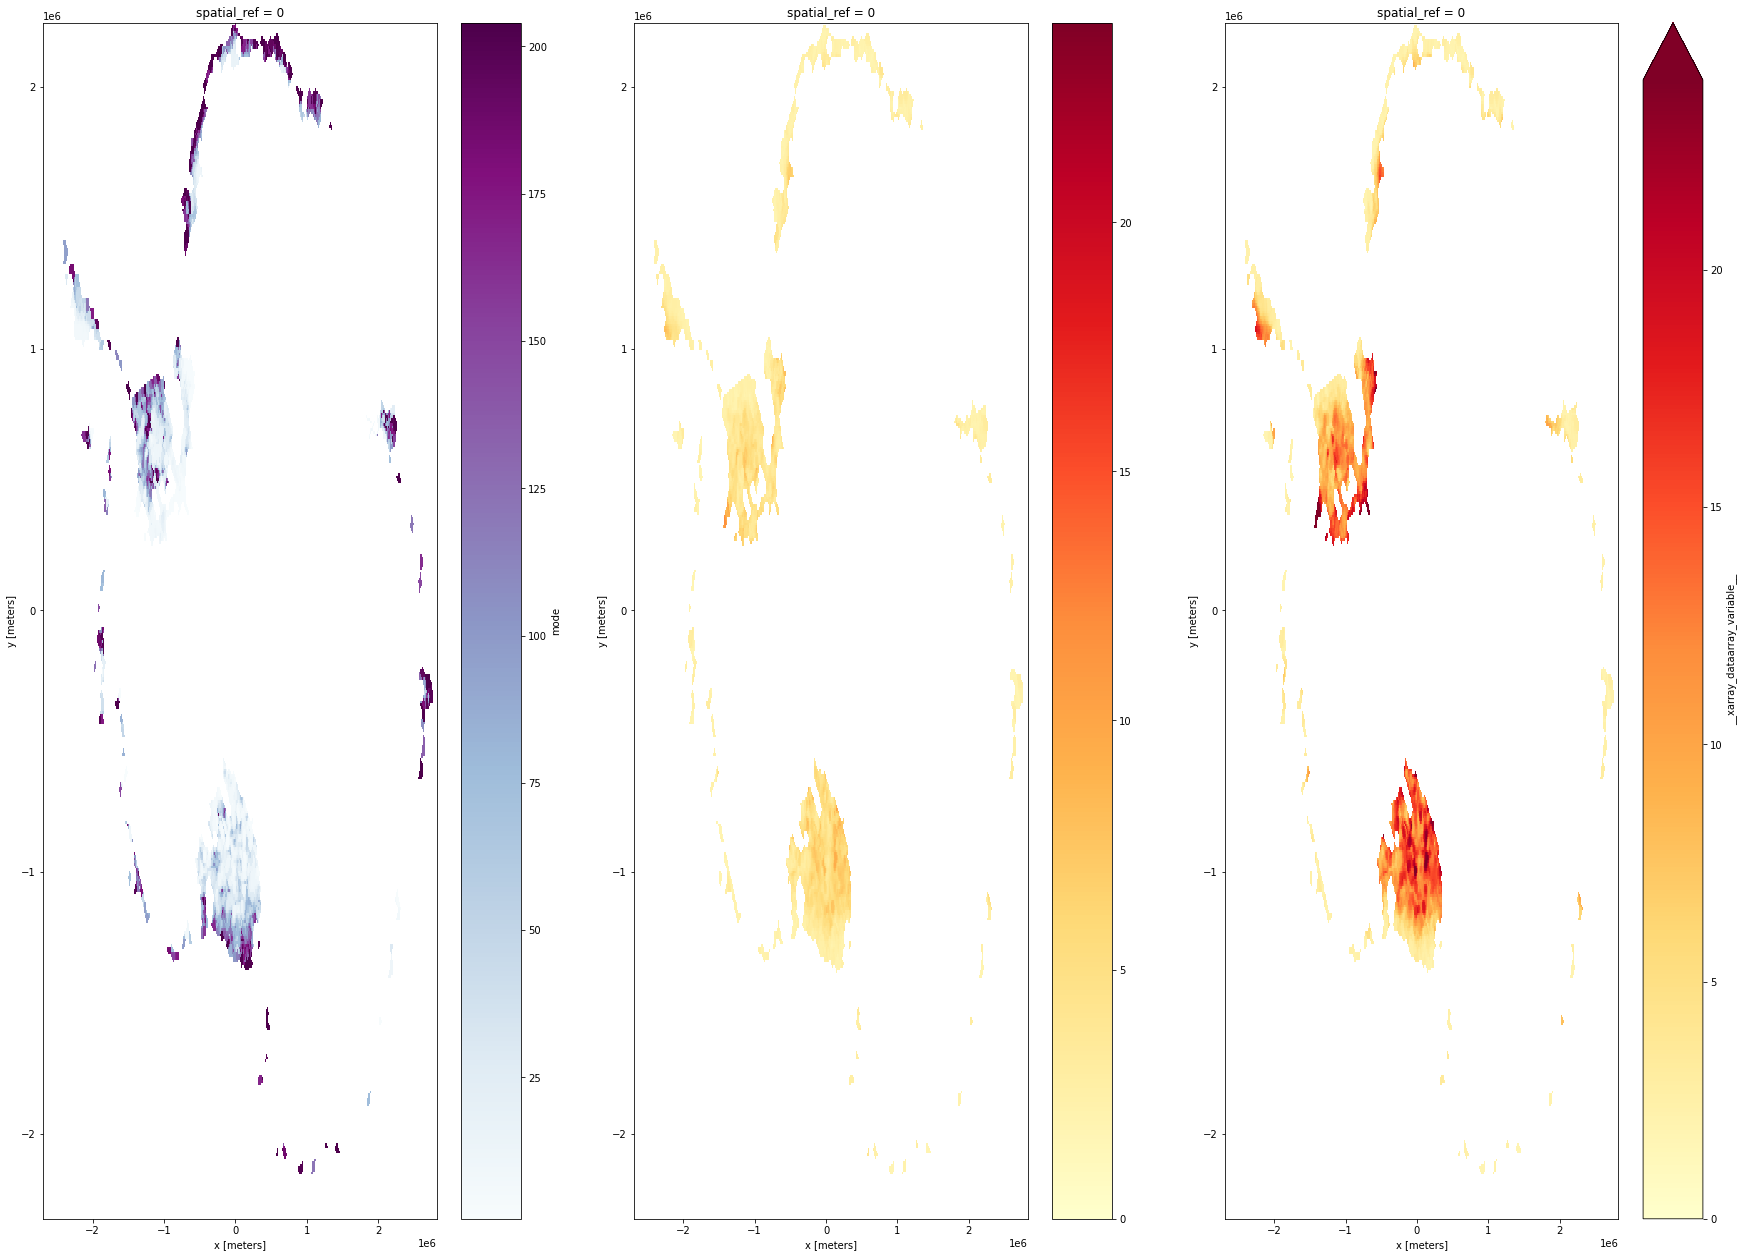

In [318]:
plt.figure(figsize=(30,12))
plt.axes(projection=ccrs.SouthPolarStereo())

plt.subplot(131)
eof_minrmse.plot(cmap="BuPu", 
#                 vmax = 30, 
#                 vmin = 0
                )

plt.subplot(132)
minrmse.plot(cmap="YlOrRd", 
                 vmax = 24, 
                 vmin = 0
                )

plt.subplot(133)
dsa = xr.open_dataset(inFilesResultsDir+'rmse_grid_comparisons_EOF_1500.nc')
dsa = dsa.__xarray_dataarray_variable__
#plt.axes(projection=ccrs.SouthPolarStereo())
dsa.plot(cmap="YlOrRd", 
         vmax = 24, 
         vmin = 0
        )

In [319]:
eof_minrmse.to_netcdf("eof_minrmse205.nc")
minrmse.to_netcdf("minrmse205.nc")

In [320]:
eof_minrmse205 = xr.open_dataset("eof_minrmse205.nc")
minrmse205 = xr.open_dataset("minrmse205.nc")

In [326]:
eof_minrmse205 = eof_minrmse205.mode
minrmse205 = minrmse205.__xarray_dataarray_variable__

NameError: name 'eof_minrmse205' is not defined

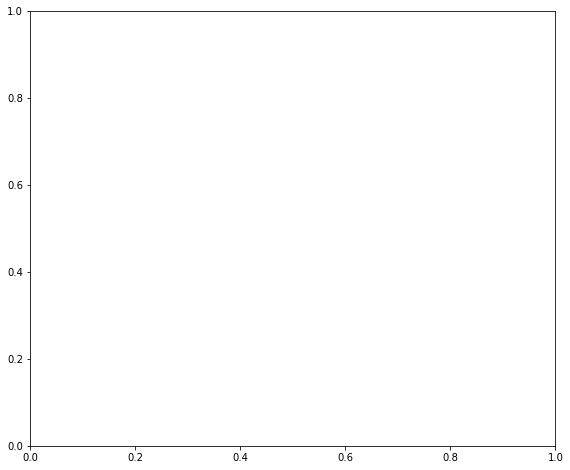

In [26]:
plt.figure(figsize=(32,8))
plt.axes(projection=ccrs.SouthPolarStereo())

plt.subplot(131)
eof_minrmse205.plot(cmap="BuPu", 
#                 vmax = 30, 
#                 vmin = 0
                )

plt.subplot(132)
minrmse205.plot(cmap="YlOrRd", 
                 vmax = 24, 
                 vmin = 0
                )

plt.subplot(133)
dsa = xr.open_dataset(inFilesResultsDir+'rmse_grid_comparisons_EOF_1500.nc')
dsa = dsa.__xarray_dataarray_variable__
#plt.axes(projection=ccrs.SouthPolarStereo())
dsa.plot(cmap="YlOrRd", 
         vmax = 24, 
         vmin = 0
        )